### 1. Data Download
Data was downloaded with following [script](./download_data.sh). For the train services tables I included the ones from 2019 to 2024 excluding 2025 cause it's not available for the full year yet.

### 2. Preparing stations table

In [1]:
import duckdb

db = duckdb.connect("data/duckdb_trains.db")

db.sql("""
CREATE TABLE IF NOT EXISTS stations AS
FROM "data/stations-2023.csv"
""")

### 3. Creating `distances` and `distances_long` tables

In [2]:
db.sql("""
CREATE TABLE IF NOT EXISTS distances AS
FROM read_csv("data/inter-station-2022.csv", nullstr='XXX')
""")

In [3]:
db.sql("""
CREATE TABLE distances_long AS
    UNPIVOT distances
    ON COLUMNS (* EXCLUDE station)
    INTO NAME other_station VALUE distance;
""")

In [4]:
db.sql("SHOW TABLES")

┌────────────────┐
│      name      │
│    varchar     │
├────────────────┤
│ distances      │
│ distances_long │
│ stations       │
└────────────────┘

### 4. Preparing `disruptions` table in Postgres

In [5]:
conn_string = "host=localhost user=postgres password=postgres dbname=postgres"

db.sql(f"""
ATTACH IF NOT EXISTS '{conn_string}' AS postgres_db (TYPE postgres);
""")

In [6]:
db.sql("""
CREATE TABLE IF NOT EXISTS postgres_db.disruptions AS
FROM "data/disruptions-*.csv"
""")

### 5. Transforming `services` table to parquet

In [7]:
duckdb.sql("""
COPY (SELECT * FROM "data/services-*.csv") TO "data/services.parquet" (FORMAT PARQUET, COMPRESSION zstd);
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
db.sql("""
CREATE TABLE IF NOT EXISTS services AS
FROM "data/services.parquet"
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [9]:
db.sql("SHOW TABLES")

┌────────────────┐
│      name      │
│    varchar     │
├────────────────┤
│ distances      │
│ distances_long │
│ services       │
│ stations       │
└────────────────┘

### 7. Queries

#### 1.

In [10]:
db.sql("""
SELECT COUNT(*) FROM services
WHERE "Stop:Station name" = 'Amsterdam Centraal'
    AND "Stop:Departure time" is not NULL
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      1667971 │
└──────────────┘

#### 2.

In [11]:
db.sql("""
SELECT "Service:Type", round(mean("Stop:Arrival delay"), 2) as average_delay FROM services
WHERE "STOP:Arrival delay" is not NULL
GROUP BY "Service:Type"
ORDER BY average_delay DESC
""")

┌──────────────────────┬───────────────┐
│     Service:Type     │ average_delay │
│       varchar        │    double     │
├──────────────────────┼───────────────┤
│ Alpen Express        │         31.84 │
│ Krokus Express       │          18.3 │
│ European Sleeper     │         12.18 │
│ Nightjet             │          9.01 │
│ Eurostar             │          6.91 │
│ Thalys               │           5.4 │
│ ICE International    │          5.31 │
│ Int. Trein           │          4.95 │
│ Nachttrein           │          4.28 │
│ Stoomtrein           │          3.37 │
│     ·                │            ·  │
│     ·                │            ·  │
│     ·                │            ·  │
│ Metro ipv trein      │           0.0 │
│ Tram ipv trein       │           0.0 │
│ Taxibus ipv trein    │           0.0 │
│ Metro                │           0.0 │
│ Belbus               │           0.0 │
│ Metro i.p.v. trein   │           0.0 │
│ stoptrein            │           0.0 │
│ Tram i.p.v. tr

#### 3.

In [12]:
db.sql("""
SELECT year("start_time") as year, MODE("cause_en") as most_common_disruption_cause FROM postgres_db.disruptions
GROUP BY year
ORDER BY year
""")

┌───────┬──────────────────────────────┐
│ year  │ most_common_disruption_cause │
│ int64 │           varchar            │
├───────┼──────────────────────────────┤
│  2011 │ broken down train            │
│  2012 │ points failure               │
│  2013 │ points failure               │
│  2014 │ broken down train            │
│  2015 │ broken down train            │
│  2016 │ broken down train            │
│  2017 │ broken down train            │
│  2018 │ broken down train            │
│  2019 │ broken down train            │
│  2020 │ broken down train            │
│  2021 │ broken down train            │
│  2022 │ broken down train            │
│  2023 │ broken down train            │
├───────┴──────────────────────────────┤
│ 13 rows                    2 columns │
└──────────────────────────────────────┘

#### 4.

In [13]:
db.sql("""
SELECT COUNT(*) FROM services
WHERE "Stop:Arrival time" is not NULL
       AND "Stop:Station name" LIKE 'Amsterdam%';
""")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      7499014 │
└──────────────┘

#### 5.

For this query I had to use the `stations` table in order to join the information about the country in which the certain station is located. In order to compute the fraction I added a binary column, when 1 means that certain service ended outside Netherlands and 0 otherwise, the average of this column tells us a desired fraction.

In [22]:
db.sql("""
SELECT ROUND(AVG(CASE WHEN stations.country <> 'NL' THEN 1 ELSE 0 END), 3) as fraction FROM services
LEFT JOIN stations on "Stop:Station code" = stations.code
""")

┌──────────┐
│ fraction │
│  double  │
├──────────┤
│    0.052 │
└──────────┘

#### 6.

Query similar to the one above, I had to `stations` to filter pairs of stations that are both in Netherlands.

In [23]:
db.sql("""
SELECT max(distance) FROM distances_long as ds
INNER JOIN stations as st on ds.station = st.code
INNER JOIN stations as st2 on ds.other_station = st2.code
WHERE st.country = 'NL' and st2.country = 'NL'
""")

┌───────────────┐
│ max(distance) │
│     int64     │
├───────────────┤
│           426 │
└───────────────┘

#### 7.

In [24]:
arrival_delays = db.sql("""
    SELECT "Service:Company", AVG(COALESCE("Stop:Arrival delay", 0)) as avg_delay from services
    GROUP BY "Service:Company"
    ORDER BY avg_delay DESC
""").df()

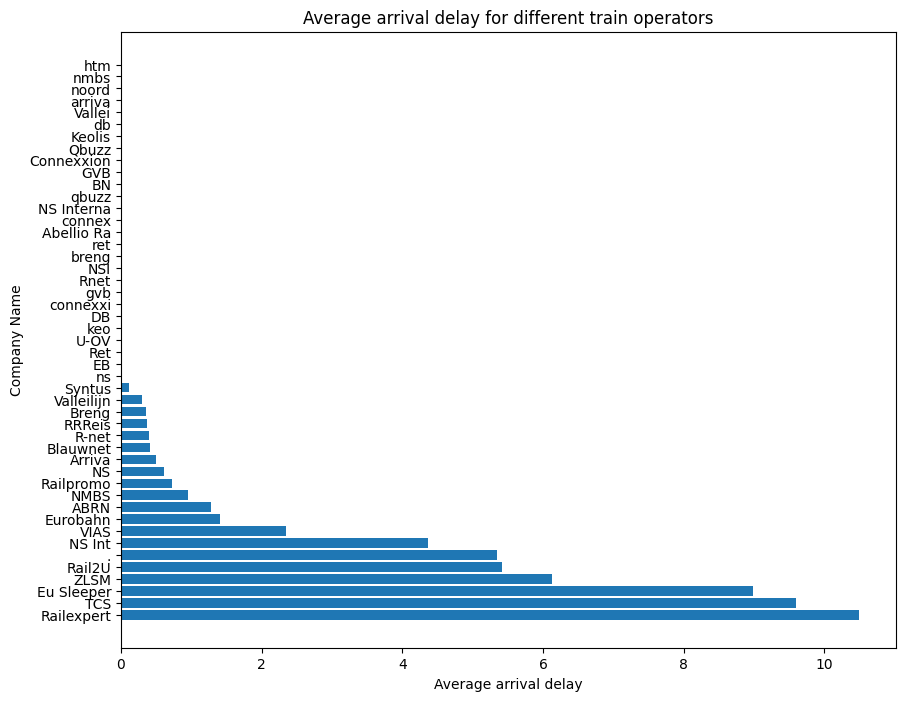

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

ax.barh(arrival_delays["Service:Company"], arrival_delays["avg_delay"])
ax.set_ylabel("Company Name")
ax.set_xlabel("Average arrival delay")

plt.title("Average arrival delay for different train operators")
plt.show()

#### 8.

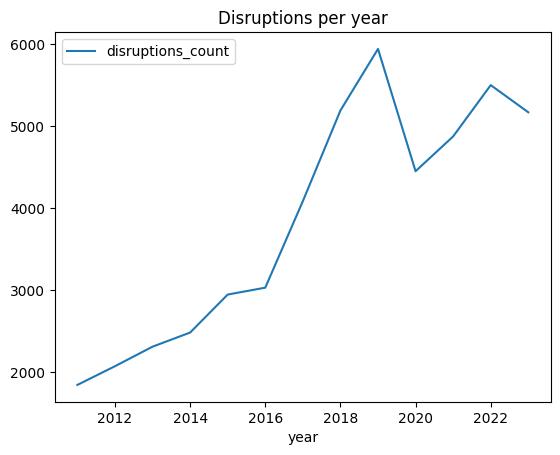

In [26]:
db.sql("""
SELECT YEAR(start_time) as year, COUNT(*) as disruptions_count FROM postgres_db.disruptions
GROUP BY year
ORDER BY year
""").df().plot.line(x="year", y="disruptions_count", title="Disruptions per year");

#### 9.

To compute the fraction, I used an approach similar to the one in questions no. 5.

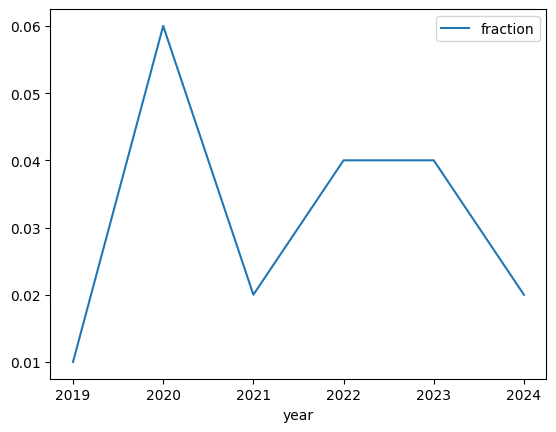

In [27]:
db.sql("""
SELECT 
    YEAR("Service:Date") as year, 
    ROUND(AVG(CASE WHEN "Service:Completely cancelled" = true THEN 1 ELSE 0 END), 2) as fraction
FROM services
GROUP BY year
ORDER BY year
""").df().plot.line(x="year", y="fraction");

### 3. Preparing `station_connections` table

In order to create a table I use a window function partitioned by "Service:RDT-ID", I order the stations in a window by COALESCE("Stop:Departure time", 'infinity') so that the row with Departure time as NULL ends up at the end. Then I retrieve the first and last elements from every window.

After that we are not done yet, if lets say the train route was a -> b -> c -> d, then we have the table with following rows

start | end | departure_time <br>
a     | b   | t1 <br>
a     | c   | t2 <br>
a     | d   | NULL <br>

So we need to filter out the rows where the departure time is NULL. This filtering is obviosuly done outside the subquery. I also need to join information about distances between stations.

In [28]:
db.sql("""
CREATE TABLE station_connections AS
SELECT "Service:RDT-ID", start_station_code, end_station_code, dl.distance FROM (
    SELECT
        "Service:RDT-ID",
        FIRST_VALUE("Stop:Station code") OVER w as start_station_code,
        LAST_VALUE("Stop:Station code") OVER w end_station_code,
        "Stop:Departure time" as dep_time
    FROM services
    WINDOW
    w AS (PARTITION BY "Service:RDT-ID" ORDER BY COALESCE("Stop:Departure time", 'infinity'))
) AS subquery
LEFT JOIN distances_long as dl on dl.station = start_station_code and dl.other_station = end_station_code
WHERE dep_time is NULL
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [29]:
db.sql("SELECT max(distance) FROM station_connections")

┌───────────────┐
│ max(distance) │
│     int64     │
├───────────────┤
│           396 │
└───────────────┘

<Axes: title={'center': 'Distance distribution'}, xlabel='end-to-end distance', ylabel='Frequency'>

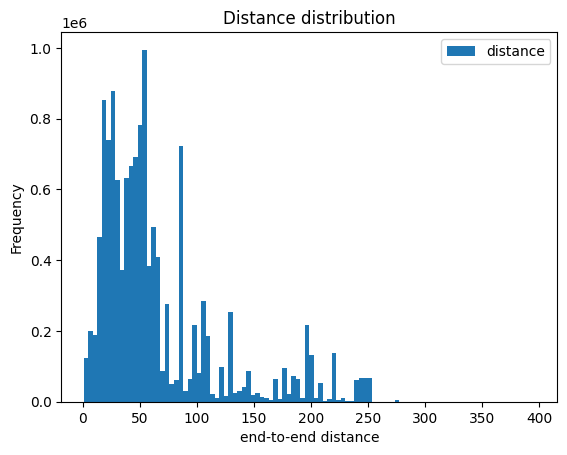

In [30]:
db.sql("SELECT distance FROM station_connections").df().plot.hist(bins=100, xlabel="end-to-end distance", title="Distance distribution")